In [1]:
from __future__ import print_function
import six

In [2]:
import yaml
import numpy
import pandas
import toyplot.pdf

print("yaml version:    ", yaml.__version__)
print("numpy version:   ", numpy.__version__)
print("pandas version:  ", pandas.__version__)
print("toyplot version: ", toyplot.__version__)

yaml version:     3.12
numpy version:    1.13.1
pandas version:   0.20.3
toyplot version:  0.15.1


Load the data, which has already been processed into a YAML file.

In [3]:
yaml_data = yaml.load(file('external-faces-log-tesla-p100-2017-04-13.yaml', 'r'))
data = pandas.DataFrame(yaml_data)
#data.head(5)

In [4]:
print('Host:         ', data['hostname'][0])
print('VTK-m version:', data['vtkm-version'][0])

Host:          ride22
VTK-m version: 1.0.0-1140-g451930f


The YAML data is hierarchical. The basic yaml reader to DataFrame just embeds dictionaries and lists in DataFrame columns. Fix that by expanding the data of these columns into new columns.

In [5]:
def expand_single_column(original_data, column_to_expand):
    expanded_data = pandas.DataFrame()
    for index in original_data.index:
        sub_table = pandas.DataFrame(original_data[column_to_expand][index])
        for column in original_data.columns:
            if column != column_to_expand:
                sub_table[column] = numpy.full(sub_table.index.shape,
                                               original_data[column][index],
                                               dtype=original_data[column].dtype)
        expanded_data = expanded_data.append(sub_table, ignore_index=True)
    return expanded_data

def expand_columns(original_data, columns_to_expand):
    if isinstance(columns_to_expand, six.string_types):
        return expand_single_column(original_data, columns_to_expand)
    else:
        expanded_data = original_data
        for column in columns_to_expand:
            expanded_data = expand_single_column(expanded_data, column)
        return expanded_data

In [6]:
flat_data = expand_columns(data, ['experiments', 'trials'])
#flat_data.columns

Rename the algorithms to match those in the paper.

In [7]:
flat_data['full-name'].replace('Sort Id3', 'SortByID', inplace=True)
flat_data['full-name'].replace('Sort XOR Indices', 'Sort+XOR', inplace=True)
flat_data['full-name'].replace('Sort FNV1A', 'Sort+FNV1a', inplace=True)
flat_data['full-name'].replace('Sort Morton', 'Sort+Morton', inplace=True)
flat_data['full-name'].replace('Hash Fight XOR Indices', 'Hash-Fight+XOR', inplace=True)
flat_data['full-name'].replace('Hash Fight FNV1A', 'Hash-Fight+FNV1a', inplace=True)
flat_data['full-name'].replace('Hash Fight Morton', 'Hash-Fight+Morton', inplace=True)

## Compare hash functions per grid

In this section we are going to pick a particular input grid and compare the (average) time that each has function and algorithm takes to complete. To do this, we first create a pivot table that aggregates the data based on these collections.

In [8]:
pivot_data = \
    flat_data.pivot_table(values='seconds-total', 
                          index='full-name',
                          columns=['size-x', 'topology-connections'],
                          aggfunc='mean')
    
ordered_names = ['SortByID',
                 'Sort+XOR',
                 'Sort+FNV1a',
                 'Sort+Morton',
                 'Hash-Fight+XOR',
                 'Hash-Fight+FNV1a',
                 'Hash-Fight+Morton']
pivot_data = pivot_data.reindex(ordered_names)

pivot_data

size-x                      100                  128                  150  \
topology-connections randomized   regular randomized   regular randomized   
full-name                                                                   
SortByID               0.308637  0.145622   0.675036  0.295014   1.125115   
Sort+XOR               0.243612  0.177998   0.518147  0.268754   0.703915   
Sort+FNV1a             0.051005  0.047896   0.096207  0.089819   0.150827   
Sort+Morton            0.052261  0.044423   0.215230  0.164280   0.167630   
Hash-Fight+XOR         0.218616  0.110921   0.472573  0.165673   0.657076   
Hash-Fight+FNV1a       0.061989  0.045656   0.111410  0.076808   0.171541   
Hash-Fight+Morton      0.066587  0.048249   0.210106  0.123967   0.196271   

size-x                                175                  200            
topology-connections   regular randomized   regular randomized   regular  
full-name                                                                 
SortByID              0.472215   1.883940  0.746356   3.007792  1.114024  
Sort+XOR              0.551519   0.967344  0.734405   1.868647  1.281336  
Sort+FNV1a            0.141086   0.236905  0.219564   0.353488  0.328329  
Sort+Morton           0.135824   0.280761  0.224998   0.388607  0.303325  
Hash-Fight+XOR        0.281049   0.905830  0.392024   1.765756  0.638073  
Hash-Fight+FNV1a      0.115702   0.262702  0.177506   0.386715  0.250945  
Hash-Fight+Morton     0.124962   0.330595  0.204807   0.442572  0.261740

The following function is a convenient way to make a table for a given grid size/topology.

In [9]:
def make_table(size, topology):
    time_data = pandas.DataFrame({'Algorithm':ordered_names,
                                  'Seconds':pivot_data[size][topology],
                                  'Seconds2':pivot_data[size][topology]})
    
    canvas = toyplot.Canvas(width='9in', height='3in')
    table = canvas.table(time_data,
                         label='{}<sup>3</sup> Grid, {} Topology'.format(size, topology))
    table.top.cell[0,1:3].merge().data = 'Time (seconds)'
    table.body.column[0].align = 'left'
    table.body.column[1].format = toyplot.format.FloatFormatter('{:.2f}s')

    table.body.column[0].width = '1.4in'
    table.body.column[1].width = '0.5in'

    axes = table.body.column[2].cartesian()
    axes.cell_bars(width=1.0)
    
    return canvas

There are a lot of mesh sizes that we computed, so let's just start with the smallest grids first.

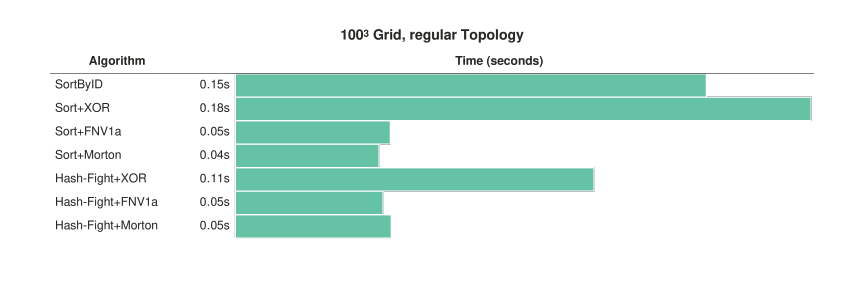

In [10]:
make_table(100, 'regular')

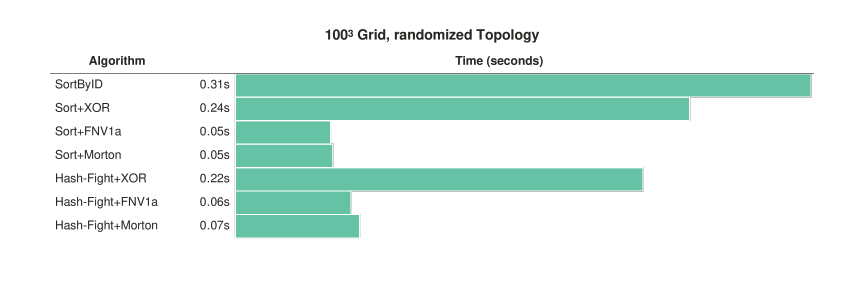

In [11]:
make_table(100, 'randomized')

From these measurements, it looks like the FNV1A and Morton hashes have about the same amount of performance. It also looks like the sort and hash fight algorithms take about the same amount of time. That is interesting because in Lesley's original paper he found that the hash fight won out more on the randomized meshes.

Next we look at the largeset grids.

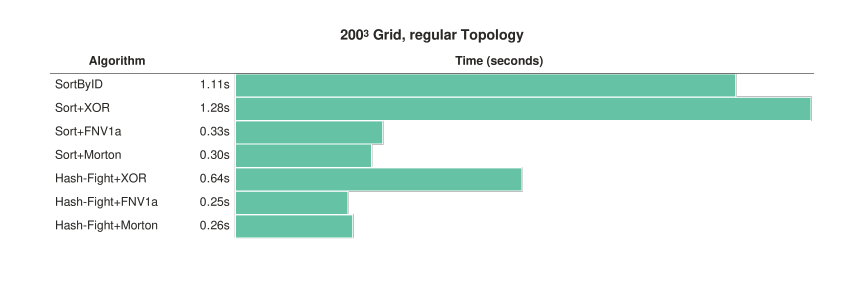

In [12]:
make_table(200, 'regular')

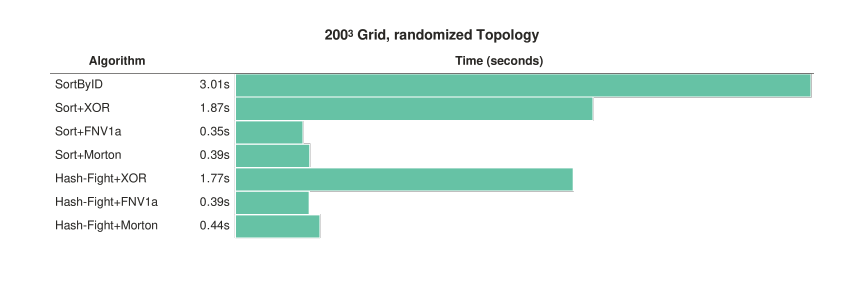

In [13]:
make_table(200, 'randomized')

The results for the largest grid are similar to that of the smallest one. The difference between FNV1A and Morton is pretty minimal, although FNV1A is usually slightlyt better. The hash fight now has a small but (probably) statistically significant advantage over sorting with the regular topology, but is slightly worse if the grid is randomized. Once again, this is the opposite of what was originally reported.

Sorting based on Id3 is clearly the loser.

## Trend Plots

Let us create trend plots of the algorithm behavior as we increase the size of the input.

In [14]:
pivot_data = \
    flat_data.pivot_table(index='num-input-cells',
                          columns=['topology-connections','full-name'],
                          values='seconds-total',
                          aggfunc='mean')

pivot_data

topology-connections       randomized                                   \
full-name            Hash-Fight+FNV1a Hash-Fight+Morton Hash-Fight+XOR   
num-input-cells                                                          
4851495                      0.061989          0.066587       0.218616   
10241915                     0.111410          0.210106       0.472573   
16539745                     0.171541          0.196271       0.657076   
26340120                     0.262702          0.330595       0.905830   
39402995                     0.386715          0.442572       1.765756   

topology-connections                                             \
full-name            Sort+FNV1a Sort+Morton  Sort+XOR  SortByID   
num-input-cells                                                   
4851495                0.051005    0.052261  0.243612  0.308637   
10241915               0.096207    0.215230  0.518147  0.675036   
16539745               0.150827    0.167630  0.703915  1.125115   
26340120               0.236905    0.280761  0.967344  1.883940   
39402995               0.353488    0.388607  1.868647  3.007792   

topology-connections          regular                                   \
full-name            Hash-Fight+FNV1a Hash-Fight+Morton Hash-Fight+XOR   
num-input-cells                                                          
4851495                      0.045656          0.048249       0.110921   
10241915                     0.076808          0.123967       0.165673   
16539745                     0.115702          0.124962       0.281049   
26340120                     0.177506          0.204807       0.392024   
39402995                     0.250945          0.261740       0.638073   

topology-connections                                             
full-name            Sort+FNV1a Sort+Morton  Sort+XOR  SortByID  
num-input-cells                                                  
4851495                0.047896    0.044423  0.177998  0.145622  
10241915               0.089819    0.164280  0.268754  0.295014  
16539745               0.141086    0.135824  0.551519  0.472215  
26340120               0.219564    0.224998  0.734405  0.746356  
39402995               0.328329    0.303325  1.281336  1.114024

In [15]:
grouped = flat_data.groupby(['topology-connections','full-name'])
#flat_data.loc[grouped.groups[('regular', 'Sort+Morton')]]

In [16]:
topology_connections = 'regular'
algorithms = ordered_names

canvas = toyplot.Canvas('8in', '4in')
axes = canvas.cartesian(bounds=(45,-15,6,-50),
                        xlabel='Number of Input Cells (Millions)',
                        ylabel='Time (seconds)')

#Get rid of space at left side of plot
axes.x.ticks.locator = toyplot.locator.Explicit([10,20,30,40])

#Get rid of space at top of plot
axes.y.ticks.locator = toyplot.locator.Explicit([0.0,0.5,1.0])

# Help toyplot to size the area large enough for the labels
axes.x.domain.max = 45

# This is a hack to change the default colors used by the plots.
# Hopefully future versions of toyplot will make setting this easier
palette = toyplot.color.brewer.palette('Dark2')
import itertools
axes._palette = toyplot.color.brewer.palette('Dark2')
axes._plot_colors = itertools.cycle(palette)
axes._scatterplot_colors = itertools.cycle(palette)
axes._text_colors = itertools.cycle(palette)

for alg in algorithms:
    series = pivot_data[topology_connections][alg]
    x = series.index / 1000000.0
    y = numpy.array(series)
    axes.plot(x, y)

    # Correct label placement for coincident labels
    if alg == 'Hash-Fight+FNV1a':
        vert_align = 'top'
    elif alg == 'Sort+FNV1a':
        vert_align = 'first-baseline'
    else:
        vert_align = 'middle'
    axes.text(x[-1], y[-1], alg,
              style={'text-anchor':'start',
                     '-toyplot-anchor-shift':'5pt',
                     '-toyplot-vertical-align':vert_align})
    
    dataGroup = flat_data.loc[grouped.groups[(topology_connections, alg)]]
    x = dataGroup['num-input-cells']/ 1000000.0
    y = dataGroup['seconds-total']
    axes.scatterplot(x, y)

SortByID Sort+XOR Sort+FNV1a Sort+Morton Hash-Fight+XOR Hash-Fight+FNV1a Hash-Fight+Morton 10 20 30 40 Number of Input Cells (Millions) 0 0.5 1 Time (seconds)

In [17]:
toyplot.pdf.render(canvas, 'sizextime-tesla-regular.pdf')

In [18]:
topology_connections = 'regular'
algorithms = ordered_names

canvas = toyplot.Canvas('4.5in', '2.7in')
axes = canvas.cartesian(bounds=(45,-15,6,-50),
                        xlabel='Number of Input Cells (Millions)',
                        ylabel='Time (seconds)')

#Get rid of space at left side of plot
axes.x.ticks.locator = toyplot.locator.Explicit([10,20,30,40])

#Get rid of space at top of plot
axes.y.ticks.locator = toyplot.locator.Explicit([0.0,0.5,1.0])

# Help toyplot to size the area large enough for the labels
axes.x.domain.max = 52

# This is a hack to change the default colors used by the plots.
# Hopefully future versions of toyplot will make setting this easier
palette = toyplot.color.brewer.palette('Dark2')
import itertools
axes._palette = toyplot.color.brewer.palette('Dark2')
axes._plot_colors = itertools.cycle(palette)
axes._scatterplot_colors = itertools.cycle(palette)
axes._text_colors = itertools.cycle(palette)

for alg in algorithms:
    series = pivot_data[topology_connections][alg]
    x = series.index / 1000000.0
    y = numpy.array(series)
    axes.plot(x, y)

    # Correct label placement for coincident labels
    if alg == 'Sort+FNV1a':
        baseline_shift = '70%'
    elif alg == 'Sort+Morton':
        baseline_shift = '0%'
    elif alg == 'Hash-Fight+Morton':
        baseline_shift = '-60%'
    elif alg == 'Hash-Fight+FNV1a':
        baseline_shift = '-150%'
    else:
        baseline_shift = '0'
    axes.text(x[-1], y[-1], alg,
              style={'text-anchor':'start',
                     '-toyplot-anchor-shift':'5pt',
                     'baseline-shift':baseline_shift})
    
    dataGroup = flat_data.loc[grouped.groups[(topology_connections, alg)]]
    x = dataGroup['num-input-cells']/ 1000000.0
    y = dataGroup['seconds-total']
    axes.scatterplot(x, y)

SortByID Sort+XOR Sort+FNV1a Sort+Morton Hash-Fight+XOR Hash-Fight+FNV1a Hash-Fight+Morton 10 20 30 40 Number of Input Cells (Millions) 0 0.5 1 Time (seconds)

In [19]:
toyplot.pdf.render(canvas, 'sizextime-tesla-regular-small.pdf')

In [20]:
topology_connections = 'randomized'
algorithms = ordered_names

canvas = toyplot.Canvas('8in', '4in')
axes = canvas.cartesian(bounds=(45,-15,6,-50),
                        xlabel='Number of Input Cells (Millions)',
                        ylabel='Time (seconds)')

#Get rid of space at left side of plot
axes.x.ticks.locator = toyplot.locator.Explicit([10,20,30,40])

# Help toyplot to size the area large enough for the labels
axes.x.domain.max = 45

# This is a hack to change the default colors used by the plots.
# Hopefully future versions of toyplot will make setting this easier
palette = toyplot.color.brewer.palette('Dark2')
import itertools
axes._palette = toyplot.color.brewer.palette('Dark2')
axes._plot_colors = itertools.cycle(palette)
axes._scatterplot_colors = itertools.cycle(palette)
axes._text_colors = itertools.cycle(palette)

for alg in algorithms:
    series = pivot_data[topology_connections][alg]
    x = series.index / 1000000.0
    y = numpy.array(series)
    axes.plot(x, y)

    # Correct label placement for coincident labels
    if alg == 'Hash-Fight+Morton':
        label = 'Hash-Fight+Morton<br/>&#160;'
    elif alg == 'Sort+FNV1a':
        label = '&#160;<br/>&#160;<br/>Sort+FNV1a'
    else:
        label = alg
    if alg == 'Hash-Fight+FNV1a':
        vert_align = 'top'
    elif alg == 'Sort+Morton':
        vert_align = 'first-baseline'
    else:
        vert_align = 'middle'
    axes.text(x[-1], y[-1], label,
              style={'text-anchor':'start',
                     '-toyplot-anchor-shift':'5pt',
                     '-toyplot-vertical-align':vert_align})
    
    dataGroup = flat_data.loc[grouped.groups[(topology_connections, alg)]]
    x = dataGroup['num-input-cells']/ 1000000.0
    y = dataGroup['seconds-total']
    axes.scatterplot(x, y)

SortByID Sort+XOR     Sort+FNV1a Sort+Morton Hash-Fight+XOR Hash-Fight+FNV1a Hash-Fight+Morton   10 20 30 40 Number of Input Cells (Millions) 0 1 2 3 Time (seconds)

In [21]:
toyplot.pdf.render(canvas, 'sizextime-tesla-randomized.pdf')

In [22]:
topology_connections = 'randomized'
algorithms = ordered_names

canvas = toyplot.Canvas('4.5in', '2.7in')
axes = canvas.cartesian(bounds=(45,-15,6,-50),
                        xlabel='Number of Input Cells (Millions)',
                        ylabel='Time (seconds)')

#Get rid of space at left side of plot
axes.x.ticks.locator = toyplot.locator.Explicit([10,20,30,40])

# Help toyplot to size the area large enough for the labels
axes.x.domain.max = 52

# This is a hack to change the default colors used by the plots.
# Hopefully future versions of toyplot will make setting this easier
palette = toyplot.color.brewer.palette('Dark2')
import itertools
axes._palette = toyplot.color.brewer.palette('Dark2')
axes._plot_colors = itertools.cycle(palette)
axes._scatterplot_colors = itertools.cycle(palette)
axes._text_colors = itertools.cycle(palette)

for alg in algorithms:
    series = pivot_data[topology_connections][alg]
    x = series.index / 1000000.0
    y = numpy.array(series)
    axes.plot(x, y)

    # Correct label placement for coincident labels
    if alg == 'Sort+XOR':
        baseline_shift = '30%'
    elif alg == 'Hash-Fight+XOR':
        baseline_shift = '-30%'
    elif alg == 'Hash-Fight+Morton':
        baseline_shift = '110%'
    elif alg == 'Sort+Morton':
        baseline_shift = '40%'
    elif alg == 'Hash-Fight+FNV1a':
        baseline_shift = '-60%'
    elif alg == 'Sort+FNV1a':
        baseline_shift = '-150%'
    else:
        baseline_shift = '0'
    axes.text(x[-1], y[-1], alg,
              style={'text-anchor':'start',
                     '-toyplot-anchor-shift':'5pt',
                     '-toyplot-vertical-align':vert_align,
                     'baseline-shift':baseline_shift})
    
    dataGroup = flat_data.loc[grouped.groups[(topology_connections, alg)]]
    x = dataGroup['num-input-cells']/ 1000000.0
    y = dataGroup['seconds-total']
    axes.scatterplot(x, y)

SortByID Sort+XOR Sort+FNV1a Sort+Morton Hash-Fight+XOR Hash-Fight+FNV1a Hash-Fight+Morton 10 20 30 40 Number of Input Cells (Millions) 0 1 2 3 Time (seconds)

In [23]:
toyplot.pdf.render(canvas, 'sizextime-tesla-randomized-small.pdf')

## Compare regular to randomized

For some "representative size," which is large but following the trend of sizes, compare the regular vs randomized times.

In [24]:
representative_mesh_size = 175
# The 175^3 mesh has 26,340,120 tetrahedra

In [25]:
ordered_connections = ['regular', 'random']

# Average all time values for each algorithm on regular/random representative mesh
pivot_data = \
    flat_data.pivot_table(columns='size-x',
                          index=['full-name','topology-connections'],
                          values='seconds-total',
                          aggfunc='mean')

pivot_data.reset_index(inplace=True)

# Changed randomized to random to fit better.
pivot_data['topology-connections'][pivot_data['topology-connections'] == 'randomized'] = 'random'

# Sort the rows in the order we want to show them.
pivot_data['full-name'] = pandas.Categorical(pivot_data['full-name'], ordered_names)
pivot_data['topology-connections'] = pandas.Categorical(pivot_data['topology-connections'], ordered_connections)
pivot_data.sort_values(['full-name', 'topology-connections'], inplace=True)

# Changed randomized to random to fit better.
pivot_data['topology-connections'][pivot_data['topology-connections'] == 'randomized'] = 'random'

# Create a table with the values we want
table_data = pandas.DataFrame({'Algorithm':pivot_data['full-name'],
                               'Mesh':pivot_data['topology-connections'],
                               'Seconds':pivot_data[representative_mesh_size],
                               'Bars':pivot_data[representative_mesh_size]})
table_data = table_data[['Algorithm', 'Mesh', 'Seconds', 'Bars']]

table_data

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,Algorithm,Mesh,Seconds,Bars
13,SortByID,regular,0.746356,0.746356
12,SortByID,random,1.883940,1.883940
11,Sort+XOR,regular,0.734405,0.734405
10,Sort+XOR,random,0.967344,0.967344
7,Sort+FNV1a,regular,0.219564,0.219564
6,Sort+FNV1a,random,0.236905,0.236905
9,Sort+Morton,regular,0.224998,0.224998
8,Sort+Morton,random,0.280761,0.280761
5,Hash-Fight+XOR,regular,0.392024,0.392024
4,Hash-Fight+XOR,random,0.905830,0.905830


In [26]:
canvas = toyplot.Canvas(width='4.5in', height='3in')
table = canvas.table(table_data,
                     bounds=(0,-1,1,-1))

table.top.cell[0,2:4].merge().data = 'Time (seconds)'
table.cells.column[0].align = 'left'
table.cells.column[1].align = 'left'
table.body.column[2].format = toyplot.format.FloatFormatter('{:.2f}s')

axes = table.body.column[3].cartesian()
axes.cell_bars(width=1.0)

# I hate gridlines, but they are useful for sizing columns
#table.cells.grid.vlines[...] = 'single'

table.cells.column[0].width = '1.15in'
table.cells.column[1].width = '0.6in'
table.cells.column[2].width = '0.4in'

table.body.gaps.rows[range(1,12,2)] = '0.075in'

Algorithm Mesh SortByID regular 0 . 75s SortByID random 1 . 88s Sort+XOR regular 0 . 73s Sort+XOR random 0 . 97s Sort+FNV1a regular 0 . 22s Sort+FNV1a random 0 . 24s Sort+Morton regular 0 . 22s Sort+Morton random 0 . 28s Hash-Fight+XOR regular 0 . 39s Hash-Fight+XOR random 0 . 91s Hash-Fight+FNV1a regular 0 . 18s Hash-Fight+FNV1a random 0 . 26s Hash-Fight+Morton regular 0 . 20s Hash-Fight+Morton random 0 . 33s Time (seconds)

In [27]:
toyplot.pdf.render(canvas, 'reg-vs-rand-tesla.pdf')